# Predicció de notes per fer recomanació de matrícules

El nostre objectiu d'aquest notebook és fer un ranking de notes basats amb un algoritme de predicció. Tenim un conjunt de dades normalitzades i unes altres no normalitzades, totes les proves les farem amb els dos conjunts. Hem creat un recomanador propi i l'hem integrat amb l'interfaç d'sklearn per així poder testejar de la mateixa manera que fem amb altres algoritmes d'aquesta llibreria. 

In [1]:
%matplotlib inline
from IPython.display import display
import numpy as np
import pandas as pd
import math
import random as rnd
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import seaborn as sbn

#import from utils
import sys
sys.path.append('../')
from utils import *

reg = pd.read_csv("../../../registers.csv", na_values=np.nan)
assig = pd.read_csv("../../../assigs.csv", na_values=np.nan)
conv = pd.read_csv("../../../conv.csv", na_values=np.nan)
qual = pd.read_csv("../../../qualifications.csv", na_values=np.nan)
qual_norm = pd.read_csv("../../../qualifications_normalized.csv", na_values=np.nan)

reg_info = reg[reg['id_enseny'] != 'G1042']
assig_info = assig[assig['id_enseny_assig'] != 'G1042']

df_info = pd.merge(pd.merge(qual, assig_info), reg_info)
df_info_norm = pd.merge(pd.merge(qual_norm, assig_info), reg_info)

In [2]:
# Primer del grau d'Enginyeria Informàtica
# * PROGRAMACIÓ I                -> 364288
# * DISSENY DIGITAL BÀSIC        -> 364289
# * INTRODUCCIÓ ALS ORDINADORS   -> 364290
# * ÀLGEBRA                      -> 364291
# * CÀLCUL                       -> 364292
# * MATEMÀTICA DISCRETA          -> 364293
# * FÍSICA                       -> 364294
# * ALGORÍSMICA                  -> 364298
# * PROGRAMACIÓ II               -> 364299
# * ESTRUCTURA DE DADES          -> 364301

# Segon del grau d'Enginyeria Informàtica
# * ELECTRÒNICA                              -> 364297
# * ALGORÍSMICA AVANÇADA                     -> 364300
# * DISSENY DE SOFTWARE                      -> 364303
# * ESTRUCTURA DE COMPUTADORS                -> 364305
# * INTRODUCCIÓ A LA COMPUTACIÓ CIENTÍFICA   -> 364302
# * EMPRESA                                  -> 364296
# * PROBABILITATS I ESTADÍSTICA              -> 364295
# * PROGRAMACIÓ D'ARQUITECTURES ENCASTADES   -> 364306
# * PROJECTE INTEGRAT DE SOFTWARE            -> 364304
# * SISTEMES OPERATIUS I                     -> 364307

# Tercer del grau d'Enginyeria Informàtica
# INTEL·LIGÈNCIA ARTIFICIAL              -> 364314
# SISTEMES OPERATIUS II                  -> 364308
# TALLER DE NOUS USOS DE LA INFORMÀTICA  -> 364322
# VISIÓ ARTIFICIAL                       -> 364315
# XARXES                                 -> 364309
# BASES DE DADES                         -> 364311
# FACTORS HUMANS I COMPUTACIÓ            -> 364323
# GRÀFICS I VISUALITZACIÓ DE DADES       -> 364328
# LÒGICA I LLENGUATGES                   -> 364310
# SOFTWARE DISTRIBUÏT                    -> 364312

assigs1_lbl = ['P1', 'DDB', 'IO', 'ALGE', 'CAL', 'MD', 'FIS', 'ALGO', 'P2', 'ED']
assigs2_lbl = ['ELEC', 'AA', 'DS', 'EC', 'ICC', 'EMP', 'PIE', 'PAE', 'PIS', 'SO1']
assigs3_lbl = ['IA', 'SO2', 'TNUI', 'VA', 'XAR', 'BD', 'FHIC', 'GiVD', 'LIL', 'SWD']

assigs1 = [364288, 364289, 364290, 364291, 364292, 364293, 364294, 364298, 364299, 364301]
assigs2 = [364297, 364300, 364303, 364305, 364302, 364296, 364295, 364306, 364304, 364307]
assigs3 = [364314, 364308, 364322, 364315, 364309, 364311, 364323, 364328, 364310, 364312]
assigs = assigs1 + assigs2 + assigs3

In [3]:
recomender_table = table_students(df_info, assigs)
recomender_table_norm = table_students(df_info_norm, assigs)

#No normalized data
primer = recomender_table[assigs1]
primer.columns = assigs1_lbl
segon = recomender_table[assigs2]
segon.columns = assigs2_lbl

primer_segon = recomender_table[assigs1 + assigs2]
primer_segon.columns = assigs1_lbl + assigs2_lbl
tercer = recomender_table[assigs3]
tercer.columns = assigs3_lbl

#Normalized data
primer_norm = recomender_table_norm[assigs1]
primer_norm.columns = assigs1_lbl
segon_norm = recomender_table_norm[assigs2]
segon_norm.columns = assigs2_lbl

primer_segon_norm = recomender_table_norm[assigs1 + assigs2]
primer_segon_norm.columns = assigs1_lbl + assigs2_lbl
tercer_norm = recomender_table_norm[assigs3]
tercer_norm.columns = assigs3_lbl

In [16]:
def coefPearson(x, y):
    x = np.array(x)
    x = x.reshape(x.size)
    y = np.array(y)
    y = y.reshape(y.size)
    length = len(x)
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    x_2 = y_2 = xy =0
    for i in range(length):#apliquem la fórmula del coeficient de pearson
        x_menys_mean = x[i]-x_mean
        y_menys_mean = y[i]-y_mean
        xy += (x_menys_mean)*(y_menys_mean)
        x_2 += x_menys_mean**2
        y_2 += y_menys_mean**2
    square = math.sqrt(x_2*y_2)
    if square == 0:#si square es 0 retornem 0 perquè no doni error
        return 0
    coef = float(xy)/square
    return abs(coef)

### Construcció d'un recomanador amb l'interfaç d'sklearn

Construïm un recomanador on el seu input es una matriu de NxM (alumne x assignatura, o viceversa). D'aquesta matriu agafa totes aquelles cel·les que tenen un NaN (np.nan) i prediu quina nota hauria d'anar, seguint la següent fórmula:

$$m_{a_qe_p} = \sum_{j=1}^n{\alpha_{e_pe_j}m_{a_qe_j}}$$

On:
 * $e_i$ és un estudiant
 * $a_i$ és una assignatura
 * $\alpha$ és una funció de similitud
 
Aquesta fórmula no és més que una suma ponderada, resumint, si un alumne s'assembla molt a un altre, tendiran a tenir les mateixes notes.

La aventatge que té aquest algoritme es que si transposem la matriu $m$, en comptes de tenir un recomanador col·laboratiu, tenim un recomanador basat en contingut.

A partir d'aquí hem de encapsular tot això dintre d'un estimador d'sklearn, per això hem d'heredar de `BaseEstimator` i implementar els mètodes `fit` i `predict`.

In [5]:
class Recomender(BaseEstimator):
    def __init__(self, method=coefPearson, transpose=False):
        self._m = None
        self._method = method
        self._transpose = transpose
        
    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        self._m = np.concatenate((X,y), axis=1)
        return self
    
    def predict(self, X):
        X = np.array(X)
        if len(X.shape) == 1:
            X = np.array([X])
        nan = [np.nan for i in xrange(self._m.shape[1] - X.shape[1])]
        out = np.array([])
        for xi in X:
            m = np.array(self._m)
            row = np.concatenate((xi,nan),axis=1)
            m = np.vstack((m, row))
            if self._transpose:
                m = m.T
            m_predict, idx = self._recomender(m)
            if out.shape[0] == 0:
                out = np.array([[m_predict[tuple(i)] for i in idx]])
            else:
                out = np.vstack((out, [m_predict[tuple(i)] for i in idx]))
        return out
        
    def _recomender(self, m):
        out = np.array(m)
        idx = np.argwhere(np.isnan(m))
        for i in idx:
            out[tuple(i)] = 0
            sim_sum = 0
            cols = np.argwhere(~np.isnan(m[i[0]])).T[0]

            student = m[i[0]]
            for j in range(m.shape[0]):
                cols= list(set(cols).intersection(np.argwhere(~np.isnan(m[j])).T[0]))
                if np.isnan(m[j,i[1]]) or j == i[0]:
                    continue
                alpha = self._method(student[cols], m[j,cols])
                sim_sum += alpha
                out[tuple(i)] += alpha*m[j,i[1]]
            out[tuple(i)] /= sim_sum
        return out, idx

Ara provarem el nostre recomanador basat en contingut, és a dir, en assignatures.
Per començar provem de predir les notes d'un alumne amb un expedient excel·lent, d'aquest podrem veure que treu bones notes en tot.
Ara bé, que passa si un altre alumne treu males notes a les assignatures de programació?
* **'Programació I'**        - 0.5
* **'Algorítmica'**          - 3.4
* **'Programació II'**       - 1.2
* **'Estructura de Dades'**  - 0.7

In [6]:
to_predict = [[9.00, 9.00, 9.00, 9.00, 9.3, 9.00, 7.70, 9.10, 9.30, 7.40],
              [0.50, 9.00, 9.00, 9.00, 9.3, 9.00, 7.70, 3.4, 1.2, 0.7]]
recomender = Recomender(transpose=True)
recomender.fit(primer.values, segon.values)

predicted = recomender.predict(to_predict)
print "real notes\t|\tpredictions"
for v in range(len(to_predict)):
    print "--------------------------------------"
    z1 = zip(assigs1_lbl, to_predict[v])
    z2 = zip(assigs2_lbl, predicted[v])
    z = zip(z1, z2)
    for i,j in z:
        print "%s\t%.2f\t|\t%s\t%.2f" % (i[0],i[1],j[0],j[1])

real notes	|	predictions
--------------------------------------
P1	9.00	|	ELEC	8.82
DDB	9.00	|	AA	8.78
IO	9.00	|	DS	8.77
ALGE	9.00	|	EC	8.87
CAL	9.30	|	ICC	8.81
MD	9.00	|	EMP	8.85
FIS	7.70	|	PIE	8.85
ALGO	9.10	|	PAE	8.78
P2	9.30	|	PIS	8.70
ED	7.40	|	SO1	8.88
--------------------------------------
P1	0.50	|	ELEC	6.28
DDB	9.00	|	AA	5.44
IO	9.00	|	DS	5.59
ALGE	9.00	|	EC	6.57
CAL	9.30	|	ICC	6.04
MD	9.00	|	EMP	5.86
FIS	7.70	|	PIE	5.99
ALGO	3.40	|	PAE	6.39
P2	1.20	|	PIS	5.51
ED	0.70	|	SO1	5.72


Es veu com en les assignatures de segon que no estan molt relacionades amb les suspeses a primer no es veuen afectades, però tant 'Disseny de Software' i 'Projecte integrat de software' surten suspeses. Per tant, ja el mateix recomanador ens diu les **depèndencies d'assignatures**.

### Testeig

Defineixo diferents tècniques:
 * Recomanador col·laboratiu (alumnes)
 * Recomanador basat en contingut (assignatures)
 * Random Forest Regressor (regressor)
 * Linear Regression (regressor)
 
Per cada tècnica mesurem:
 * MAE (Error promig absolut): $$ \mathrm{MAE} = \frac{1}{n}\sum_{i=1}^n \left| y_{pred}-y_{test}\right|$$
 * MSE (Error promig quadràtic): $$\mathrm{MSE}=\frac{1}{n}\sum_{i=1}^n(y_{pred}-y_{test})^2$$
 * PCC (Coeficient de pearson): $$\mathrm{PCC} =\left| \frac{\sum_{i=1}^n(y_{pred} - \bar{y}_{pred})(y_{test} - \bar{y}_{test})}{\sqrt{\sum_{i=1}^n(y_{pred} - \bar{y}_{pred})^2  \sum_{i=1}^n(y_{test} - \bar{y}_{test})^2}}\right|$$
 * std (Desviació estàndard): $$ \sigma = \sqrt{ \frac{1}{n} \sum_{i=1}^n (\left| y_{pred_i}-y_{test_i}\right| - \mu)^2 } $$
 

In [7]:
def benchmark(X,y,estimator):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    r = np.abs(y_pred - y_test)
    print "MAE (Mean Absolut Error):             %.3f" % r.mean()
    print "MSE (Mean Squared Error):             %.3f" % mean_squared_error(y_pred, y_test)
    print "PCC (Pearson Correlation Coeficient): %.3f" % coefPearson(y_pred, y_test)
    print "Std (Standard desviation):            %.3f" % r.std()
    return r.reshape(r.size)

In [8]:
estimators = [Recomender(),
              Recomender(transpose=True), 
              RandomForestRegressor(n_estimators=100, random_state=42), #42, magic number
              LinearRegression()]
estimators_lbl = ['RCxE', # Recomanador col·laboratiu per estudiant
                  'RCxA', # Recomanador col·laboratiu per assignatura
                  'RFR',  # Regressor Random Forest
                  'LR']   # Regressor lineal

#### Notes sense normalitzar

Train: primer
Test:  segon
_________________________________________________________________

Estimator: RCxE
MAE (Mean Absolut Error):             0.796
MSE (Mean Squared Error):             0.910
PCC (Pearson Correlation Coeficient): 0.578
Std (Standard desviation):            0.526

Estimator: RCxA
MAE (Mean Absolut Error):             1.006
MSE (Mean Squared Error):             1.509
PCC (Pearson Correlation Coeficient): 0.309
Std (Standard desviation):            0.705

Estimator: RFR
MAE (Mean Absolut Error):             0.868
MSE (Mean Squared Error):             1.152
PCC (Pearson Correlation Coeficient): 0.505
Std (Standard desviation):            0.632

Estimator: LR
MAE (Mean Absolut Error):             0.809
MSE (Mean Squared Error):             1.071
PCC (Pearson Correlation Coeficient): 0.575
Std (Standard desviation):            0.646



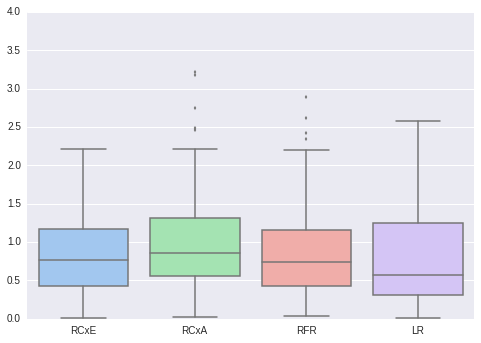

In [9]:
print "Train: primer"
print "Test:  segon"
print "_________________________________________________________________"
print
rs = []
for lbl,e  in zip(estimators_lbl, estimators):
    print "Estimator:", lbl
    rs.append(benchmark(primer.values, segon.values, e))
    print
g = sbn.boxplot(rs, color='pastel', names=estimators_lbl)
g.set(ylim=(0, 4))
sbn.despine(trim=True)

Train: primer + segon
Test:  tercer
_________________________________________________________________

Estimator: Recomender(method=None, transpose=None)
MAE (Mean Absolut Error):             0.869
MSE (Mean Squared Error):             1.590
PCC (Pearson Correlation Coeficient): 0.276
Std (Standard desviation):            0.914

Estimator: Recomender(method=None, transpose=None)
MAE (Mean Absolut Error):             0.906
MSE (Mean Squared Error):             1.781
PCC (Pearson Correlation Coeficient): 0.141
Std (Standard desviation):            0.980

Estimator: RandomForestRegressor(bootstrap=True, compute_importances=None,
           criterion='mse', max_depth=None, max_features='auto',
           max_leaf_nodes=None, min_density=None, min_samples_leaf=1,
           min_samples_split=2, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=42, verbose=0)
MAE (Mean Absolut Error):             0.786
MSE (Mean Squared Error):             1.522
PCC (Pearson Correlation Co

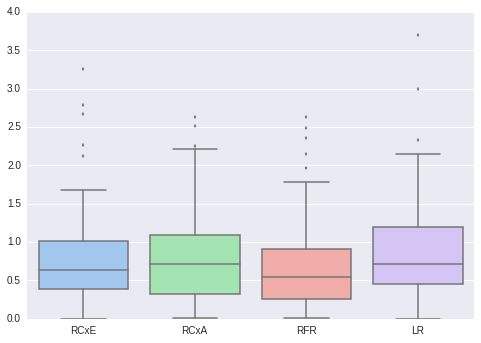

In [10]:
print "Train: primer + segon"
print "Test:  tercer"
print "_________________________________________________________________"
print
rs = []
for e  in estimators:
    print "Estimator:", e
    rs.append(benchmark(primer_segon.values, tercer.values, e))
    print
g = sbn.boxplot(rs, color='pastel', names=estimators_lbl)
g.set(ylim=(0, 4))
sbn.despine(trim=True)

#### Notes normalitzades

Train: primer
Test:  segon
_________________________________________________________________

Estimator: RCxE
MAE (Mean Absolut Error):             0.370
MSE (Mean Squared Error):             0.199
PCC (Pearson Correlation Coeficient): 0.277
Std (Standard desviation):            0.249

Estimator: RCxA
MAE (Mean Absolut Error):             0.355
MSE (Mean Squared Error):             0.219
PCC (Pearson Correlation Coeficient): 0.466
Std (Standard desviation):            0.305

Estimator: RFR
MAE (Mean Absolut Error):             0.369
MSE (Mean Squared Error):             0.205
PCC (Pearson Correlation Coeficient): 0.336
Std (Standard desviation):            0.262

Estimator: LR
MAE (Mean Absolut Error):             0.302
MSE (Mean Squared Error):             0.142
PCC (Pearson Correlation Coeficient): 0.592
Std (Standard desviation):            0.224



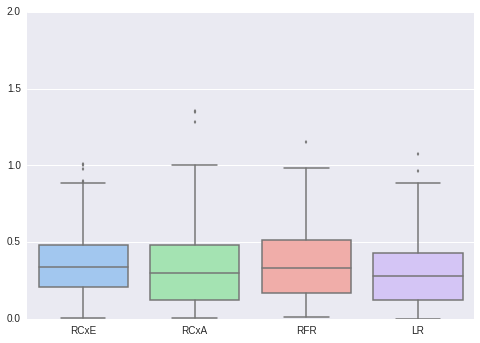

In [11]:
print "Train: primer"
print "Test:  segon"
print "_________________________________________________________________"
print
rs = []
for lbl,e  in zip(estimators_lbl, estimators):
    print "Estimator:", lbl
    rs.append(benchmark(primer_norm.values, segon_norm.values, e))
    print
g = sbn.boxplot(rs, color='pastel', names=estimators_lbl)
g.set(ylim=(0, 2))
sbn.despine(trim=True)

Train: primer + segon
Test:  tercer
_________________________________________________________________

Estimator: Recomender(method=None, transpose=None)
MAE (Mean Absolut Error):             0.410
MSE (Mean Squared Error):             0.290
PCC (Pearson Correlation Coeficient): 0.323
Std (Standard desviation):            0.349

Estimator: Recomender(method=None, transpose=None)
MAE (Mean Absolut Error):             0.458
MSE (Mean Squared Error):             0.397
PCC (Pearson Correlation Coeficient): 0.245
Std (Standard desviation):            0.434

Estimator: RandomForestRegressor(bootstrap=True, compute_importances=None,
           criterion='mse', max_depth=None, max_features='auto',
           max_leaf_nodes=None, min_density=None, min_samples_leaf=1,
           min_samples_split=2, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=42, verbose=0)
MAE (Mean Absolut Error):             0.410
MSE (Mean Squared Error):             0.324
PCC (Pearson Correlation Co

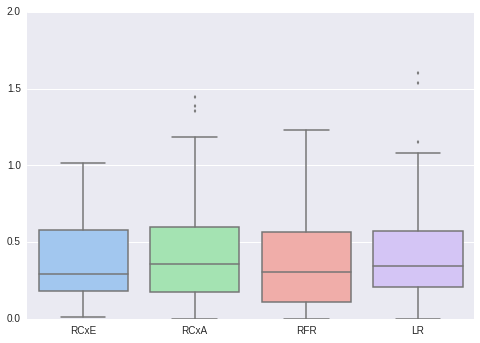

In [12]:
print "Train: primer + segon"
print "Test:  tercer"
print "_________________________________________________________________"
print
rs = []
for e  in estimators:
    print "Estimator:", e
    rs.append(benchmark(primer_segon_norm.values, tercer_norm.values, e))
    print
g = sbn.boxplot(rs, color='pastel', names=estimators_lbl)
g.set(ylim=(0, 2))
sbn.despine(trim=True)

### Ranking d'assignatures

A partir d'un bon recomanador o regressor, escollit segons el testeig, l'agafem per tal de fer un ranking d'assignatures. La finalitat és que donat un alumne poguem donar un ranking de notes ordenades des de la que li anirà bé fins la que tindrà més problemes.

In [13]:
def ranking_notes(X_train, y_train, X_test, estimator, lbl):
    estimator.fit(X_train, y_train)
    y_pred = np.squeeze(estimator.predict(X_test))
    s = sorted(zip(y_pred,lbl))[::-1]
    return s

In [15]:
# Primer del grau d'Enginyeria Informàtica
# * PROGRAMACIÓ I                -> 364288
# * DISSENY DIGITAL BÀSIC        -> 364289
# * INTRODUCCIÓ ALS ORDINADORS   -> 364290
# * ÀLGEBRA                      -> 364291
# * CÀLCUL                       -> 364292
# * MATEMÀTICA DISCRETA          -> 364293
# * FÍSICA                       -> 364294
# * ALGORÍSMICA                  -> 364298
# * PROGRAMACIÓ II               -> 364299
# * ESTRUCTURA DE DADES          -> 364301

# Segon del grau d'Enginyeria Informàtica
# * ELECTRÒNICA                              -> 364297
# * ALGORÍSMICA AVANÇADA                     -> 364300
# * DISSENY DE SOFTWARE                      -> 364303
# * ESTRUCTURA DE COMPUTADORS                -> 364305
# * INTRODUCCIÓ A LA COMPUTACIÓ CIENTÍFICA   -> 364302
# * EMPRESA                                  -> 364296
# * PROBABILITATS I ESTADÍSTICA              -> 364295
# * PROGRAMACIÓ D'ARQUITECTURES ENCASTADES   -> 364306
# * PROJECTE INTEGRAT DE SOFTWARE            -> 364304
# * SISTEMES OPERATIUS I                     -> 364307

#input
#alumne = [7.00, 7.00, 7.00, 1.30, 5.00, 1.20, 1.70, 7.10, 6.30, 6.40]
a = 228
alumne_primer = primer.ix[a]
alumne_segon = segon.ix[a]
alumne_segon = sorted(zip(alumne_segon,assigs2_lbl))[::-1]
estimator = Recomender(transpose=False)

# drop from training, our test
primer_train = primer.drop(a)
segon_train = segon.drop(a)

# call function
s = ranking_notes(primer_train.values, segon_train.values, alumne_primer, estimator, assigs2_lbl)
print "real marks\t||\tpredictions\t|\treal marks"
print "----------------------------------------------------------"
for ((mark1, subject1), (mark2, subject2)), (mark3, subject3) in zip(zip(zip(alumne_primer,assigs1_lbl), s),alumne_segon):
    print "%.2f - %s\t||\t%.2f - %s\t|\t%.2f - %s" % (mark1, subject1, mark2, subject2, mark3, subject3)

real marks	||	predictions	|	real marks
----------------------------------------------------------
6.70 - P1	||	7.74 - PIS	|	9.50 - PIS
8.80 - DDB	||	7.46 - PAE	|	7.90 - EMP
7.40 - IO	||	7.09 - EMP	|	7.80 - PAE
5.00 - ALGE	||	7.06 - ELEC	|	7.40 - SO1
6.20 - CAL	||	6.87 - AA	|	6.70 - PIE
5.30 - MD	||	6.84 - PIE	|	6.00 - DS
5.30 - FIS	||	6.44 - ICC	|	5.80 - EC
6.70 - ALGO	||	6.18 - EC	|	5.40 - ICC
6.50 - P2	||	6.06 - DS	|	5.40 - ELEC
7.00 - ED	||	5.99 - SO1	|	5.00 - AA
